## API Reference:
This API comes from Medium.com, written by Shu Lee. Initially she wrote this to be able to show the different Oil PADDs and the production values throughout the United States. 

Reference:

Lee, S. (2020, April 13). Use Python To Pull Energy Data From The Department of Energy’s EIA API | by Shu Lee | Analytics Vidhya | Medium. Medium; Analytics Vidhya. https://medium.com/analytics-vidhya/use-python-to-pull-energy-data-from-the-us-department-of-energys-api-11d6f724927e

I have edited and arranged this API to pull information for two specific fields:

- U.S. Price of Natural Gas Delivered to Residential Consumers, Dollars per Thousand Cubic Feet / Monthly
-  Average retail price of electricity : United States : residential : monthly cents per kilowatthour / Monthly


In [1]:
#Import libraries
import pandas as pd # dataframes 
import requests # requests library, sending http requests
import matplotlib.pyplot as plt # visualizations
import numpy as np # working in arrays to convert to pandas
from datetime import date # converting date time from API

This next block is to setup the api key request. We add the key as a variable to be written into a request line. 

In [2]:
# API Key from EIA
api_key = "6f51d318524e46f6a23f302166f38959"

FIELD_NAMES = ['Resi_Gas', 'Elect_Price']
# Enter all Series IDs here separated by commas
FIELD_KEY = ['NG.N3010US3.M','ELEC.PRICE.US-RES.M']
# U.S. Price of Natural Gas Delivered to Residential Consumers, Dollars per Thousand Cubic Feet / Monthly
# Average retail price of electricity : United States : residential : monthly cents per kilowatthour / Monthly


# Initialize list - this is the final list that you will store all the data from the json pull. Then you will use this list to concat into a pandas dataframe. 
final_data = []
# Choose start and end dates
startDate = '1990-01-01'
endDate = '2021-12-28'

In [3]:
# Pull in data via EIA API
for i in range(len(FIELD_KEY)): # for loop to build json 
    url = 'http://api.eia.gov/series/?api_key=' + api_key + '&series_id=' + FIELD_KEY[i]
    r = requests.get(url)
    json_data = r.json()
    
    if r.status_code == 200:
        print('Success!')
    else:
        print('Error')
    # pull into a dataframe
    df = pd.DataFrame(json_data.get('series')[0].get('data'),
                      columns = ['Date', FIELD_NAMES[i]])
    df.set_index('Date', drop=True, inplace=True)
    # set the index as the date and append the dataframe accordingly
    final_data.append(df)



Success!
Success!


In [4]:
# Combine all the data into one dataframe
crude = pd.concat(final_data, axis=1)
# Create date as datetype datatype
crude['Year'] = crude.index.astype(str).str[:4]
crude['Month'] = crude.index.astype(str).str[4:]
crude['Day'] = 1
crude['Date'] = pd.to_datetime(crude[['Year','Month','Day']])
crude.set_index('Date',drop=True,inplace=True)
crude.sort_index(inplace=True)
crude = crude[startDate:endDate]
crude = crude.iloc[:,:2] # <--- how many columns to show

#### Quick check of the data to make sure it is loaded. 

In [5]:
crude.head() 

,Resi_Gas,Elect_Price
Date,,
1990-01-01,5.43,NaN
1990-02-01,5.65,NaN
1990-03-01,5.60,NaN
1990-04-01,5.64,NaN
1990-05-01,6.00,NaN


We do see null values. This shows that electrical prices were not formally recorded until the year 2000. This will be addressed in later notebooks when we begin data cleaning. 

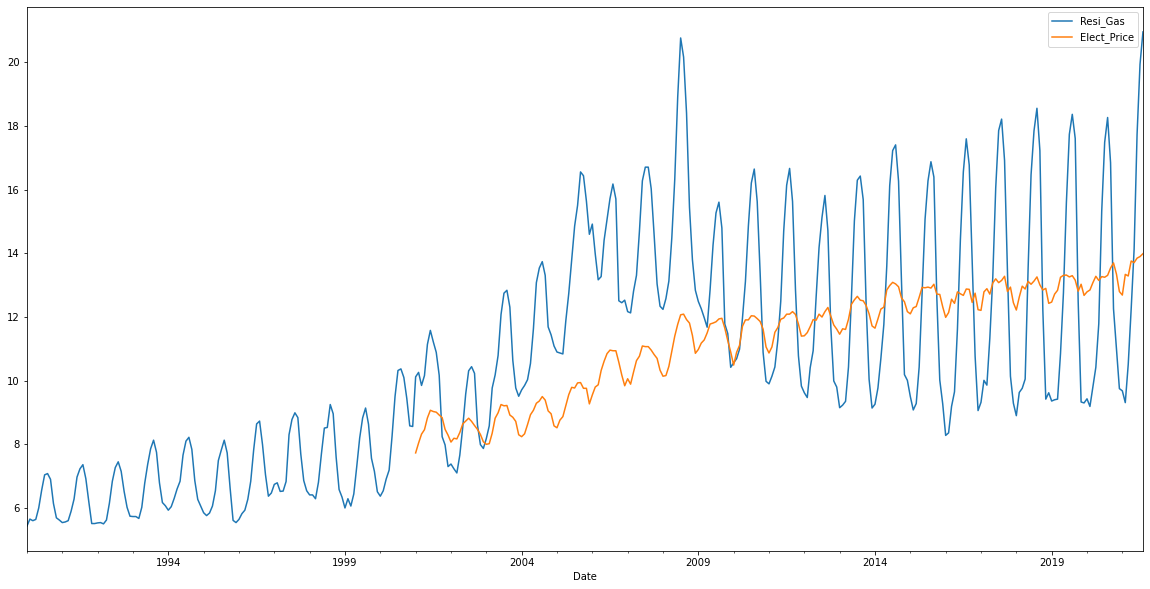

In [6]:
crude.plot(figsize=(20,10))
plt.show()

In [7]:
crude.describe()

,Resi_Gas,Elect_Price
count,380.000000,248.000000
mean,10.600132,11.315565
std,3.683819,1.663766
min,5.430000,7.730000
25%,7.377500,9.885000
50%,10.000000,11.830000
75%,13.087500,12.720000
max,20.960000,13.990000


A quick plot visualization to show Electricity vs Gas. Just very high-level we can see the dramatic swings between Gas vs electrcity. The next block will show some central tendency measurements. This does not include removing null. However, when we look at the standard deviation it is almost 3x higher than electricity. My hypothesis is in the form a t-test. 

Ho:  The means of residential gas and electricity prices are not different.

Ha:  The means of residential gas and electricity prices are different. 

Since we will address null values in a later notebook I will not simply dropna() for the time being to get an appropriate t-test. We can visualize to see differences. Significant differences in kurtosis, which checks out given our differences in standard deviations. This may also be due to the wild differences in weather. Gas is at a higher price seasonally.

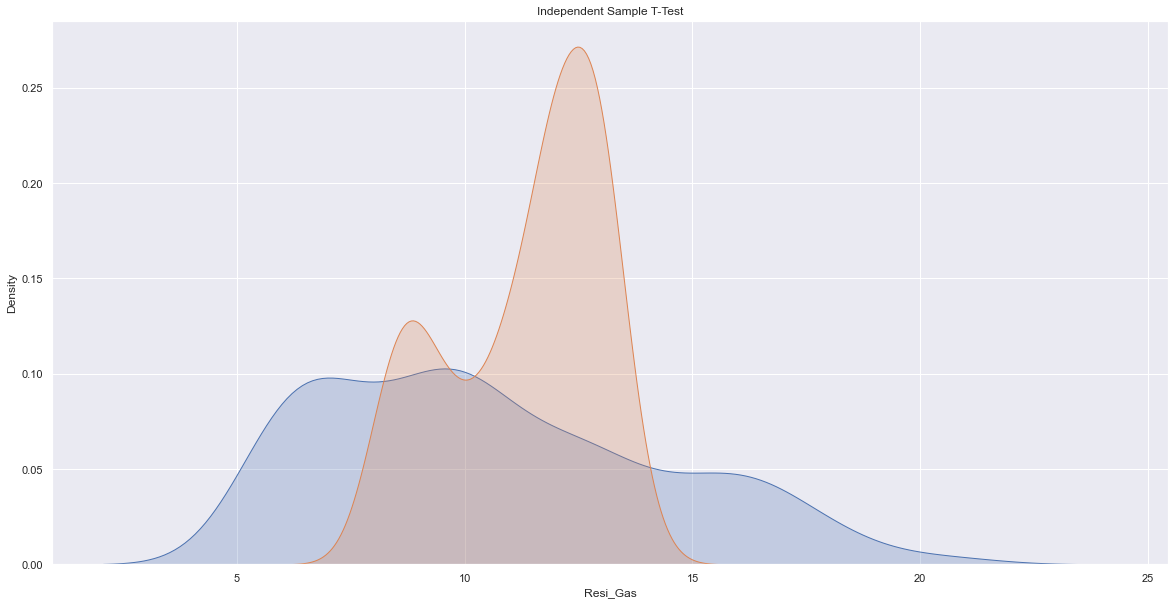

In [8]:
import seaborn as sns
sns.set(rc={"figure.figsize":(20, 10)})
sns.kdeplot(crude['Resi_Gas'].dropna(), shade=True)
sns.kdeplot(crude['Elect_Price'].dropna(), shade=True)
plt.title("Independent Sample T-Test")
plt.show()

In [9]:
from scipy import stats
tStat, pValue = stats.ttest_ind(crude['Resi_Gas'].dropna(), crude['Elect_Price'].dropna(), 
                                equal_var = False) #run independent sample T-Test
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat)) #print the P-Value and the T-Statistic

P-Value:0.0010114521197977064 T-Statistic:-3.3044906170581076


A p-value of 0.001 states we can reject the null. The means of these two price populations are statistically different. 

#### A quick check on correlations

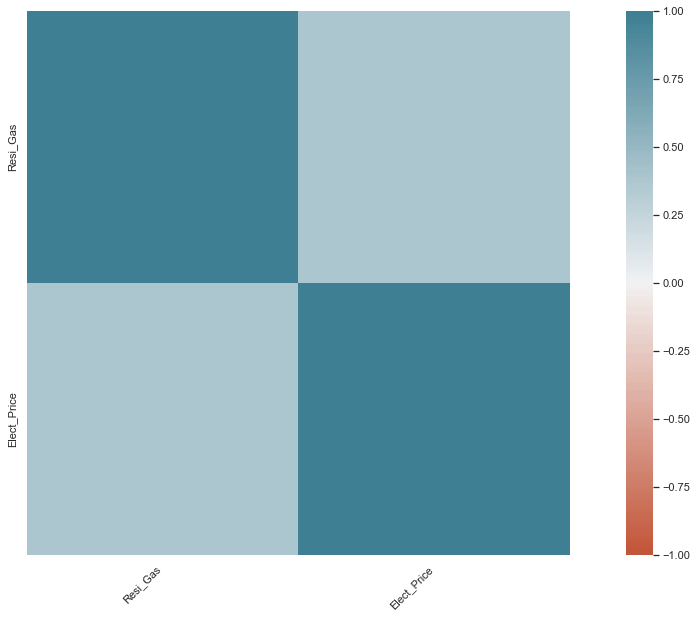

In [17]:

corr = crude.dropna().corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

### A quick note on pandas_profiling library

I am a sucker for fun libraries that summarize small datasets like this with only two fields. This will give us a quick EDA report on the two price indexes. After this we will reset the index for the date and export to CSV.

In [11]:
import pandas_profiling

In [12]:
crude.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Prep for joining later datasets

#### I reset the index so we can join on the date column

In [13]:
crude_reset = crude.reset_index() 

In [14]:
crude_reset.tail()

,Date,Resi_Gas,Elect_Price
375,2021-04-01,12.25,13.76
376,2021-05-01,14.13,13.71
377,2021-06-01,17.73,13.85
378,2021-07-01,19.94,13.90
379,2021-08-01,20.96,13.99


#### Export to CSV file

In [15]:
crude_reset.to_csv('EIA.csv')